## 설치

In [ ]:
!pip install ydata_profiling
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.9/357.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 8.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 13.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=2ee2ed195abf554cb2dabdf247f8e9f99ee8bad0ec0afb097fa566dda40f8564
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pand

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport

import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ndcg_score, make_scorer
from sklearn.preprocessing import LabelBinarizer, LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from scipy.stats import randint as sp_randint
from scipy.stats import chi2_contingency

from google.colab import auth
from google.colab import drive
auth.authenticate_user()

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/prj4/airbnb/'

Mounted at /content/gdrive


In [ ]:
def set_random_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
random_seed = 1106
set_random_seed(random_seed)

## load data

In [ ]:
train = pd.read_csv(path + 'users_data2.csv')
train.rename(columns={'id': 'user_id'}, inplace=True)
train.head(2)

user_id date_account_created timestamp_first_active date_first_booking  \
0  d1mm9tcy42           2014-01-01    2014-01-01 00:09:36         2014-01-04   
1  yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58         2015-07-01   

      gender   age signup_method  signup_flow language affiliate_channel  ...  \
0       MALE  62.0         basic            0       en     sem-non-brand  ...   
1  -unknown-  35.0         basic            0       en            direct  ...   

  first_browser country_destination id_row_counts age_modified days_to_book  \
0        Chrome               other           127            0            4   
1       Firefox                 NDF             9            1          547   

  logs_per_day  total_elapsed  booking  month  day  
0    31.750000      3427529.0        1      1    1  
1     0.016453       207842.0        0      1    1  

[2 rows x 24 columns]

In [ ]:
session = pd.read_csv(path + 'filtered_sessions.csv')
session.head(2)

id          action action_type        action_detail  \
0  d1mm9tcy42          lookup         NaN                  NaN   
1  d1mm9tcy42  search_results       click  view_search_results   

       device_type  secs_elapsed  
0  Windows Desktop         319.0  
1  Windows Desktop       67753.0

In [ ]:
session['action'] = session['action'].fillna('error')
session["action_type"] = session["action_type"].fillna('-unknown-')
session["action_detail"] = session["action_detail"].fillna('-unknown-')
session["secs_elapsed"] = session["secs_elapsed"].fillna(0)

In [ ]:
# user_flow 컬럼 생성
session['user_flow'] = session['action'].astype('str') + '+' + session['action_type'].astype('str') + '+' + session['action_detail'].astype('str')
session.rename(columns={'id': 'user_id'}, inplace=True)

## profile

In [ ]:
profile1 = ProfileReport(train, title="Profiling Report :: user info")
profile1

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# profile2 = ProfileReport(session, title="Profiling Report :: sessions")
# profile2

## action columns 전처리

- action+type+detail = user_flow로 묶고 user_id 별 모든 user_flow를 한 string으로 합치기
- train과 머지했을 때 중복을 피하기 위함
- 구분자는 쉼표

In [ ]:
user_flows_concatenated = session.groupby('user_id')['user_flow'].apply(lambda x: ','.join(x)).reset_index()

session = pd.merge(session.drop(columns=['user_flow']), user_flows_concatenated, on='user_id', how='left')
session

user_id            action action_type        action_detail  \
0        d1mm9tcy42            lookup   -unknown-            -unknown-   
1        d1mm9tcy42    search_results       click  view_search_results   
2        d1mm9tcy42            lookup   -unknown-            -unknown-   
3        d1mm9tcy42    search_results       click  view_search_results   
4        d1mm9tcy42            lookup   -unknown-            -unknown-   
...             ...               ...         ...                  ...   
5537952  nw9fwlyb5f             index        data         reservations   
5537953  nw9fwlyb5f  unavailabilities        data    unavailable_dates   
5537954  nw9fwlyb5f     notifications      submit        notifications   
5537955  nw9fwlyb5f            search       click  view_search_results   
5537956  nw9fwlyb5f            search       click  view_search_results   

             device_type  secs_elapsed  \
0        Windows Desktop         319.0   
1        Windows Desktop       67753.0   
2        Windows Desktop         301.0   
3        Windows Desktop       22141.0   
4        Windows Desktop         435.0   
...                  ...           ...   
5537952           iPhone         245.0   
5537953           iPhone         286.0   
5537954           iPhone         830.0   
5537955           iPhone      101961.0   
5537956           iPhone       10863.0   

                                                 user_flow  
0        lookup+-unknown-+-unknown-,search_results+clic...  
1        lookup+-unknown-+-unknown-,search_results+clic...  
2        lookup+-unknown-+-unknown-,search_results+clic...  
3        lookup+-unknown-+-unknown-,search_results+clic...  
4        lookup+-unknown-+-unknown-,search_results+clic...  
...                                                    ...  
5537952  show+view+user_profile,show+view+p3,reviews+da...  
5537953  show+view+user_profile,show+view+p3,reviews+da...  
5537954  show+view+user_profile,show+view+p3,reviews+da...  
5537955  show+view+user_profile,show+view+p3,reviews+da...  
5537956  show+view+user_profile,show+view+p3,reviews+da...  

[5537957 rows x 7 columns]

In [ ]:
session_df = session.copy()

## feature engineering
- user_id별 평균 세션 시간 생성
- user_id별 가장 많이 쓴 주요 device_type 생성
- user_id별 세션 총 개수 생성

In [ ]:
# user_id별 평균 secs_elapsed column 생성
session_df['mean_secs_elapsed'] = session_df.groupby('user_id')['secs_elapsed'].transform('mean')
# user_id별 가장 빈도수가 높은 device_type column 생성
session_df['most_frequent_device'] = session_df.groupby('user_id')['device_type'].transform(lambda x: x.mode()[0])
# user_id별 세션 총 개수
session_df['session_count'] = session_df.groupby('user_id')['action'].transform('count')

In [ ]:
session_df2 = session_df.copy()

In [ ]:
session_df2.drop(['action', 'action_type', 'action_detail', 'device_type', 'secs_elapsed'], axis=1, inplace=True)

In [ ]:
session_df2.drop_duplicates(subset='user_id', inplace=True)

In [ ]:
session_df2

user_id                                          user_flow  \
0        d1mm9tcy42  lookup+-unknown-+-unknown-,search_results+clic...   
127      yo8nz8bqcq  dashboard+view+dashboard,create+submit+create_...   
136      4grx6yxeby  verify+-unknown-+-unknown-,create+submit+creat...   
152      ncf87guaf0  lookup+-unknown-+-unknown-,show+view+p3,search...   
304      4rvqpxoh3h  campaigns+-unknown-+-unknown-,active+-unknown-...   
...             ...                                                ...   
5537475  zxodksqpep  edit+view+edit_profile,edit+view+edit_profile,...   
5537585  mhewnxesx9  confirm_email+click+confirm_email_link,dashboa...   
5537823  6o3arsjbb4  ajax_refresh_subtotal+click+change_trip_charac...   
5537841  jh95kwisub  search+click+view_search_results,search+click+...   
5537916  nw9fwlyb5f  show+view+user_profile,show+view+p3,reviews+da...   

         mean_secs_elapsed most_frequent_device  session_count  
0             26988.417323      Windows Desktop            127  
127           23093.555556          Mac Desktop              9  
136           70965.250000      Windows Desktop             16  
152           24704.605263      Windows Desktop            152  
304             319.375000               iPhone              8  
...                    ...                  ...            ...  
5537475       46739.963636          Mac Desktop            110  
5537585       12096.319328      Windows Desktop            238  
5537823       19054.555556          Mac Desktop             18  
5537841        4554.786667               iPhone             75  
5537916       67297.804878               iPhone             41  

[73815 rows x 5 columns]

## 가설

#### 필수 함수들

In [ ]:
def cramers_v(confusion_matrix):
    """Calculate Cramer's V statistic for categorical-categorical association."""
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

In [ ]:
users = train.copy()
users['country_destination_modified'] = users['country_destination'].apply(
    lambda x: x if x in ['NDF', 'US', 'other'] else 'rest'
)
users.head()

user_id date_account_created timestamp_first_active date_first_booking  \
0  d1mm9tcy42           2014-01-01    2014-01-01 00:09:36         2014-01-04   
1  yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58         2015-07-01   
2  4grx6yxeby           2014-01-01    2014-01-01 00:16:39         2015-07-01   
3  ncf87guaf0           2014-01-01    2014-01-01 00:21:46         2015-07-01   
4  4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19         2014-01-02   

      gender   age signup_method  signup_flow language affiliate_channel  ...  \
0       MALE  62.0         basic            0       en     sem-non-brand  ...   
1  -unknown-  35.0         basic            0       en            direct  ...   
2  -unknown-  39.0         basic            0       en         sem-brand  ...   
3  -unknown-  37.0         basic            0       en            direct  ...   
4  -unknown-  34.0         basic           25       en            direct  ...   

  country_destination id_row_counts age_modified days_to_book logs_per_day  \
0               other           127            0            4    31.750000   
1                 NDF             9            1          547     0.016453   
2                 NDF            16            1          547     0.029250   
3                 NDF           152            1          547     0.277879   
4                  GB             8            1            2     4.000000   

  total_elapsed  booking  month  day  country_destination_modified  
0     3427529.0        1      1    1                         other  
1      207842.0        0      1    1                           NDF  
2     1135444.0        0      1    1                           NDF  
3     3755100.0        0      1    1                           NDF  
4        2555.0        1      1    1                          rest  

[5 rows x 25 columns]

#### signup

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['signup_flow'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1607.1730260097534
P-value: 3.6754380522992317e-292
Degrees of Freedom: 66
Expected Frequencies Table:
[[1.17555727e+02 3.40292894e+02 1.93348235e+02 5.46788810e+02
  1.10981887e+03 5.65350240e+02 7.57151690e+02 3.48343915e+04
  1.91028057e+02 6.41916142e+01 1.55413312e+04 2.82675120e+03]
 [2.38867439e-01 6.91458376e-01 3.92874077e-01 1.11104789e+00
  2.25509720e+00 1.14876380e+00 1.53849489e+00 7.07817652e+01
  3.88159588e-01 1.30434194e-01 3.15792183e+01 5.74381901e+00]
 [8.11737452e+00 2.34976631e+01 1.33509449e+01 3.77564723e+01
  7.66344239e+01 3.90381630e+01 5.22823003e+01 2.40535964e+03
  1.31907336e+01 4.43251372e+00 1.07314895e+03 1.95190815e+02]
 [6.17760618e-03 1.78825442e-02 1.01605365e-02 2.87339972e-02
  5.83214794e-02 2.97094087e-02 3.97886608e-02 1.83056289e+00
  1.00386100e-02 3.37329811e-03 8.16703922e-01 1.48547043e-01]
 [4.45199485e+00 1.28873535e+01 7.32235995e+00 2.07076339e+01
  4.20303461e+01 2.14105805e+01 2.86743616e+01 1.31922566e+03
  7

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['signup_app'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1654.0772666740465
P-value: 0.0
Degrees of Freedom: 33
Expected Frequencies Table:
[[7.78172458e+00 2.25260448e+01 1.27988891e+01 3.61952584e+01
  7.34656235e+01 3.74239518e+01 5.01204498e+01 2.30589906e+03
  1.26453024e+01 4.24923119e+00 1.02877471e+03 1.87119759e+02]
 [5.37451737e+00 1.55578135e+01 8.83966673e+00 2.49985775e+01
  5.07396871e+01 2.58471855e+01 3.46161349e+01 1.59258972e+03
  8.73359073e+00 2.93476936e+00 7.10532412e+02 1.29235928e+02]
 [1.17407465e+02 3.39863713e+02 1.93104383e+02 5.46099194e+02
  1.10841916e+03 5.64637215e+02 7.56196762e+02 3.47904580e+04
  1.90787130e+02 6.41106550e+01 1.55217303e+04 2.82318607e+03]
 [2.14362934e+01 6.20524284e+01 3.52570616e+01 9.97069701e+01
  2.02375533e+02 1.03091648e+02 1.38066653e+02 6.35205324e+03
  3.48339768e+01 1.17053444e+01 2.83396261e+03 5.15458240e+02]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.0855613609833893


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['signup_method'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 187.54539970283636
P-value: 3.050748608981144e-28
Degrees of Freedom: 22
Expected Frequencies Table:
[[1.13534106e+02 3.28651358e+02 1.86733726e+02 5.28082978e+02
  1.07185159e+03 5.46009415e+02 7.31249272e+02 3.36426950e+04
  1.84492921e+02 6.19955971e+01 1.50096569e+04 2.73004708e+03]
 [3.73456885e+01 1.08105941e+02 6.14238298e+01 1.73706591e+02
  3.52572783e+02 1.79603278e+02 2.40535718e+02 1.10663629e+04
  6.06867439e+01 2.03927115e+01 4.93724744e+03 8.98016392e+02]
 [1.12020592e+00 3.24270135e+00 1.84244395e+00 5.21043148e+00
  1.05756283e+01 5.38730610e+00 7.21501050e+00 3.31942071e+02
  1.82033462e+00 6.11691391e-01 1.48095645e+02 2.69365305e+01]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.03348703848590661


In [ ]:
# 세 컬럼을 묶어서 새로운 컬럼 'affiliate' 생성
users['signup'] = users['signup_method'] + '_' + users['signup_flow'].astype(str) + '_' + users['signup_app']

In [ ]:
country_dest_freq = users.groupby('signup')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
signup                                                              
basic_0_Android               1.000000  0.000000  0.000000  0.000000
basic_0_Moweb                 0.811321  0.156334  0.021563  0.010782
basic_0_Web                   0.566356  0.294924  0.056203  0.082518
basic_12_Android              0.840000  0.123810  0.020952  0.015238
basic_23_Android              0.780369  0.156725  0.040130  0.022777
basic_23_Web                  0.500000  0.500000  0.000000  0.000000
basic_24_Android              1.000000  0.000000  0.000000  0.000000
basic_24_Moweb                0.678613  0.262045  0.028790  0.030552
basic_24_Web                  0.644444  0.311111  0.000000  0.044444
basic_24_iOS                  0.571429  0.428571  0.000000  0.000000
basic_25_Web                  0.800000  0.000000  0.000000  0.200000
basic_25_iOS                  0.745786  0.189218  0.031587  0.033409
basic_8_Android               0.50

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['signup'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 2168.862053685768
P-value: 6.80463219733394e-263
Degrees of Freedom: 341
Expected Frequencies Table:
[[2.05920206e-03 5.96084807e-03 3.38684549e-03 9.57799905e-03
  1.94404931e-02 9.90313622e-03 1.32628869e-02 6.10187631e-01
  3.34620335e-03 1.12443270e-03 2.72234641e-01 4.95156811e-02]
 [7.63963964e-01 2.21147463e+00 1.25651968e+00 3.55343765e+00
  7.21242295e+00 3.67406354e+00 4.92053106e+00 2.26379611e+02
  1.24144144e+00 4.17164533e-01 1.00999052e+02 1.83703177e+01]
 [9.04607465e+01 2.61860056e+02 1.48784122e+02 4.20761498e+02
  8.54020863e+02 4.35044774e+02 5.82638624e+02 2.68055426e+04
  1.46998713e+02 4.93963287e+01 1.19592678e+04 2.17522387e+03]
 [1.08108108e+00 3.12944523e+00 1.77809388e+00 5.02844950e+00
  1.02062589e+01 5.19914651e+00 6.96301565e+00 3.20348506e+02
  1.75675676e+00 5.90327169e-01 1.42923186e+02 2.59957326e+01]
 [3.79716860e+00 1.09918038e+01 6.24534309e+00 1.76618303e+01
  3.58482693e+01 1.82613832e+01 2.44567635e+01 1.12518599e+03
  6.1

In [ ]:
# 세 컬럼을 묶어서 새로운 컬럼 'affiliate' 생성
users['signup'] = users['signup_flow'].astype(str) + '_' + users['signup_app']

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['signup'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1870.9884544611346
P-value: 9.029808528316944e-270
Degrees of Freedom: 198
Expected Frequencies Table:
[[4.11840412e-03 1.19216961e-02 6.77369098e-03 1.91559981e-02
  3.88809862e-02 1.98062724e-02 2.65257739e-02 1.22037526e+00
  6.69240669e-03 2.24886541e-03 5.44469281e-01 9.90313622e-02]
 [1.13667954e+00 3.29038813e+00 1.86953871e+00 5.28705548e+00
  1.07311522e+01 5.46653119e+00 7.32111359e+00 3.36823572e+02
  1.84710425e+00 6.20686852e-01 1.50273522e+02 2.73326560e+01]
 [1.16414929e+02 3.36990585e+02 1.91471923e+02 5.41482598e+02
  1.09904884e+03 5.59863903e+02 7.49804051e+02 3.44963475e+04
  1.89174260e+02 6.35686785e+01 1.53905132e+04 2.79931952e+03]
 [3.26589447e+00 9.45390503e+00 5.37153695e+00 1.51907065e+01
  3.08326221e+01 1.57063740e+01 2.10349387e+01 9.67757583e+02
  5.30707851e+00 1.78335027e+00 4.31764140e+02 7.85318702e+01]
 [6.87773488e-01 1.99092325e+00 1.13120639e+00 3.19905168e+00
  6.49312470e+00 3.30764750e+00 4.42980424e+00 2.03802669e+02
  1

In [ ]:
country_dest_freq = users.groupby('signup')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
signup                                                              
0_Android                     0.500000  0.500000  0.000000  0.000000
0_Moweb                       0.804348  0.163043  0.016304  0.016304
0_Web                         0.572027  0.293982  0.054940  0.079050
12_Android                    0.796343  0.158890  0.025221  0.019546
12_Moweb                      0.661677  0.284431  0.035928  0.017964
12_Web                        0.647059  0.117647  0.058824  0.176471
12_iOS                        0.704738  0.232419  0.029925  0.032918
21_Web                        1.000000  0.000000  0.000000  0.000000
23_Android                    0.771442  0.168289  0.037089  0.023180
23_Web                        0.800000  0.200000  0.000000  0.000000
24_Android                    0.750000  0.187500  0.000000  0.062500
24_Moweb                      0.678074  0.261601  0.029002  0.031323
24_Web                        0.69

#### 주말 (X)

In [ ]:
# 요일로 확인
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['weekday'] = users['date_account_created'].dt.day_name()
users

user_id date_account_created timestamp_first_active  \
0      d1mm9tcy42           2014-01-01    2014-01-01 00:09:36   
1      yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58   
2      4grx6yxeby           2014-01-01    2014-01-01 00:16:39   
3      ncf87guaf0           2014-01-01    2014-01-01 00:21:46   
4      4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19   
...           ...                  ...                    ...   
73810  zxodksqpep           2014-06-30    2014-06-30 23:56:36   
73811  mhewnxesx9           2014-06-30    2014-06-30 23:57:19   
73812  6o3arsjbb4           2014-06-30    2014-06-30 23:57:54   
73813  jh95kwisub           2014-06-30    2014-06-30 23:58:22   
73814  nw9fwlyb5f           2014-06-30    2014-06-30 23:58:24   

      date_first_booking     gender   age signup_method  signup_flow language  \
0             2014-01-04       MALE  62.0         basic            0       en   
1             2015-07-01  -unknown-  35.0         basic            0       en   
2             2015-07-01  -unknown-  39.0         basic            0       en   
3             2015-07-01  -unknown-  37.0         basic            0       en   
4             2014-01-02  -unknown-  34.0         basic           25       en   
...                  ...        ...   ...           ...          ...      ...   
73810         2015-07-01       MALE  32.0         basic            0       en   
73811         2015-07-01  -unknown-  37.0         basic            0       en   
73812         2015-07-01  -unknown-  32.0         basic            0       en   
73813         2015-07-01  -unknown-  35.0         basic           25       en   
73814         2015-07-01  -unknown-  34.0         basic           25       en   

      affiliate_channel  ... total_elapsed booking month day  \
0         sem-non-brand  ...     3427529.0       1     1   1   
1                direct  ...      207842.0       0     1   1   
2             sem-brand  ...     1135444.0       0     1   1   
3                direct  ...     3755100.0       0     1   1   
4                direct  ...        2555.0       1     1   1   
...                 ...  ...           ...     ...   ...  ..   
73810         sem-brand  ...     5141396.0       0     6  30   
73811            direct  ...     2878924.0       0     6  30   
73812            direct  ...      342982.0       0     6  30   
73813             other  ...      341609.0       0     6  30   
73814            direct  ...     2759210.0       0     6  30   

      country_destination_modified                al     signup    generation  \
0                            other            omg_en  basic_Web  Baby Boomers   
1                              NDF      untracked_en  basic_Web             1   
2                              NDF            omg_en  basic_Web             1   
3                              NDF         linked_en  basic_Web             1   
4                             rest      untracked_en  basic_iOS             1   
...                            ...               ...        ...           ...   
73810                          NDF            omg_en  basic_Web   Millennials   
73811                          NDF         linked_en  basic_Web             1   
73812                          NDF      untracked_en  basic_Web   Millennials   
73813                          NDF  tracked-other_en  basic_iOS             1   
73814                          NDF      untracked_en  basic_iOS             1   

                   gm    weekday  
0      Baby Boomers_1  Wednesday  
1                 1_1  Wednesday  
2                 1_1  Wednesday  
3                 1_1  Wednesday  
4                 1_1  Wednesday  
...               ...        ...  
73810   Millennials_6     Monday  
73811             1_6     Monday  
73812   Millennials_6     Monday  
73813             1_6     Monday  
73814             1_6     Monday  

[73815 rows x 30 columns]

In [ ]:
country_dest_freq = users.groupby('weekday')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
weekday                                                             
Friday                        0.614415  0.277136  0.044582  0.063866
Monday                        0.603792  0.271429  0.049824  0.074956
Saturday                      0.618314  0.263195  0.049136  0.069355
Sunday                        0.613798  0.259610  0.052305  0.074287
Thursday                      0.604440  0.282682  0.051510  0.061368
Tuesday                       0.615184  0.269937  0.049743  0.065136
Wednesday                     0.604653  0.276911  0.049650  0.068785


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['weekday'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 117.22844279274685
P-value: 0.00010621375528263291
Degrees of Freedom: 66
Expected Frequencies Table:
[[  21.57014157   62.43988349   35.47720653  100.32954007  203.63916548
   103.73535189  138.92874077 6391.71543724   35.05148005   11.77843257
  2851.65786087  518.67675947]
 [  23.35135135   67.59601707   38.40682788  108.61450925  220.45519203
   112.30156472  150.40113798 6919.52773826   37.94594595   12.75106686
  3087.14082504  561.50782361]
 [  17.51763192   50.7089345    28.8118946    81.48003793  165.38027501
    84.24597981  112.82737926 5190.86617896   28.46615187    9.56554901
  2315.90008806  421.22989907]
 [  18.26718147   52.87868319   30.04470636   84.96642959  172.45661451
    87.8507214   117.65507011 5412.97447673   29.68416988    9.97484251
  2414.99349726  439.25360699]
 [  23.18661519   67.11914922   38.13588024  107.84826932  218.89995258
   111.50931383  149.34010702 6870.71272777   37.67824968   12.66111224
  3065.36205378  557.54656913]
 

In [ ]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])

# 'weekday' 컬럼 생성: 주말(토요일, 일요일)인 경우 1, 그렇지 않으면 0
users['weekday'] = users['date_account_created'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

users

user_id date_account_created timestamp_first_active  \
0      d1mm9tcy42           2014-01-01    2014-01-01 00:09:36   
1      yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58   
2      4grx6yxeby           2014-01-01    2014-01-01 00:16:39   
3      ncf87guaf0           2014-01-01    2014-01-01 00:21:46   
4      4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19   
...           ...                  ...                    ...   
73810  zxodksqpep           2014-06-30    2014-06-30 23:56:36   
73811  mhewnxesx9           2014-06-30    2014-06-30 23:57:19   
73812  6o3arsjbb4           2014-06-30    2014-06-30 23:57:54   
73813  jh95kwisub           2014-06-30    2014-06-30 23:58:22   
73814  nw9fwlyb5f           2014-06-30    2014-06-30 23:58:24   

      date_first_booking     gender   age signup_method  signup_flow language  \
0             2014-01-04       MALE  62.0         basic            0       en   
1             2015-07-01  -unknown-  35.0         basic            0       en   
2             2015-07-01  -unknown-  39.0         basic            0       en   
3             2015-07-01  -unknown-  37.0         basic            0       en   
4             2014-01-02  -unknown-  34.0         basic           25       en   
...                  ...        ...   ...           ...          ...      ...   
73810         2015-07-01       MALE  32.0         basic            0       en   
73811         2015-07-01  -unknown-  37.0         basic            0       en   
73812         2015-07-01  -unknown-  32.0         basic            0       en   
73813         2015-07-01  -unknown-  35.0         basic           25       en   
73814         2015-07-01  -unknown-  34.0         basic           25       en   

      affiliate_channel  ... age_modified days_to_book logs_per_day  \
0         sem-non-brand  ...            0            4    31.750000   
1                direct  ...            1          547     0.016453   
2             sem-brand  ...            1          547     0.029250   
3                direct  ...            1          547     0.277879   
4                direct  ...            1            2     4.000000   
...                 ...  ...          ...          ...          ...   
73810         sem-brand  ...            0          367     0.299728   
73811            direct  ...            1          367     0.648501   
73812            direct  ...            0          367     0.049046   
73813             other  ...            1          367     0.204360   
73814            direct  ...            1          367     0.111717   

      total_elapsed booking month  day  country_destination_modified  \
0         3427529.0       1     1    1                         other   
1          207842.0       0     1    1                           NDF   
2         1135444.0       0     1    1                           NDF   
3         3755100.0       0     1    1                           NDF   
4            2555.0       1     1    1                          rest   
...             ...     ...   ...  ...                           ...   
73810     5141396.0       0     6   30                           NDF   
73811     2878924.0       0     6   30                           NDF   
73812      342982.0       0     6   30                           NDF   
73813      341609.0       0     6   30                           NDF   
73814     2759210.0       0     6   30                           NDF   

                 affiliate  weekday  
0               google_omg        0  
1         direct_untracked        0  
2               google_omg        0  
3            direct_linked        0  
4         direct_untracked        0  
...                    ...      ...  
73810           google_omg        0  
73811        direct_linked        0  
73812     direct_untracked        0  
73813  other_tracked-other        0  
73814     direct_untracked        0  

[73815 rows x 27 columns]

In [ ]:
country_dest_freq = users.groupby('weekday')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
weekday                                                             
0                             0.608395  0.275582  0.049134  0.066889
1                             0.616009  0.261365  0.050754  0.071872


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['weekday'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 36.5369733327732
P-value: 0.00013772706830121533
Degrees of Freedom: 11
Expected Frequencies Table:
[[1.16215187e+02 3.36412382e+02 1.91143399e+02 5.40553532e+02
  1.09716311e+03 5.58903299e+02 7.48517551e+02 3.44371593e+04
  1.88849678e+02 6.34596085e+01 1.53641064e+04 2.79451649e+03]
 [3.57848134e+01 1.03587618e+02 5.88566010e+01 1.66446468e+02
  3.37836890e+02 1.72096701e+02 2.30482449e+02 1.06038407e+04
  5.81503218e+01 1.95403915e+01 4.73089359e+03 8.60483506e+02]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.018600048390325894


#### affliate (X)

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['affiliate_channel'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1046.7115308298332
P-value: 5.880142427547085e-170
Degrees of Freedom: 77
Expected Frequencies Table:
[[5.73281853e+00 1.65950010e+01 9.42897785e+00 2.66651494e+01
  5.41223329e+01 2.75703312e+01 3.69238773e+01 1.69876237e+03
  9.31583012e+00 3.13042065e+00 7.57901240e+02 1.37851656e+02]
 [3.35855856e+00 9.72214320e+00 5.52394500e+00 1.56217165e+01
  3.17074443e+01 1.61520152e+01 2.16317686e+01 9.95216027e+02
  5.45765766e+00 1.83394974e+00 4.44014699e+02 8.07600759e+01]
 [9.63994852e+01 2.79051141e+02 1.58551785e+02 4.48384448e+02
  9.10087245e+02 4.63605419e+02 6.20888790e+02 2.85653238e+04
  1.56649163e+02 5.26391926e+01 1.27443925e+04 2.31802709e+03]
 [1.73590734e+00 5.02499492e+00 2.85511075e+00 8.07425320e+00
  1.63883357e+01 8.34834383e+00 1.11806137e+01 5.14388173e+02
  2.82084942e+00 9.47896769e-01 2.29493802e+02 4.17417192e+01]
 [1.42084942e+00 4.11298517e+00 2.33692339e+00 6.60881935e+00
  1.34139403e+01 6.83316399e+00 9.15139199e+00 4.21029466e+02
  2.

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['affiliate_provider'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 382.06655822327343
P-value: 2.682503437111603e-17
Degrees of Freedom: 176
Expected Frequencies Table:
[[2.67696268e-02 7.74910249e-02 4.40289914e-02 1.24513988e-01
  2.52726411e-01 1.28740771e-01 1.72417530e-01 7.93243921e+00
  4.35006435e-02 1.46176251e-02 3.53905033e+00 6.43703854e-01]
 [1.77503218e+00 5.13825103e+00 2.91946081e+00 8.25623518e+00
  1.67577051e+01 8.53650342e+00 1.14326085e+01 5.25981738e+02
  2.88442728e+00 9.69260990e-01 2.34666260e+02 4.26825171e+01]
 [4.11840412e-03 1.19216961e-02 6.77369098e-03 1.91559981e-02
  3.88809862e-02 1.98062724e-02 2.65257739e-02 1.22037526e+00
  6.69240669e-03 2.24886541e-03 5.44469281e-01 9.90313622e-02]
 [2.05920206e-03 5.96084807e-03 3.38684549e-03 9.57799905e-03
  1.94404931e-02 9.90313622e-03 1.32628869e-02 6.10187631e-01
  3.34620335e-03 1.12443270e-03 2.72234641e-01 4.95156811e-02]
 [9.63994852e+01 2.79051141e+02 1.58551785e+02 4.48384448e+02
  9.10087245e+02 4.63605419e+02 6.20888790e+02 2.85653238e+04
  1.

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['first_affiliate_tracked'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 253.8477796773976
P-value: 7.86213965778677e-24
Degrees of Freedom: 66
Expected Frequencies Table:
[[2.94795367e+01 8.53355009e+01 4.84860801e+01 1.37118634e+02
  2.78310100e+02 1.41773298e+02 1.89871490e+02 8.73544613e+03
  4.79042471e+01 1.60973786e+01 3.89731112e+03 7.08866491e+02]
 [5.14800515e-02 1.49021202e-01 8.46711373e-02 2.39449976e-01
  4.86012328e-01 2.47578405e-01 3.31572174e-01 1.52546908e+01
  8.36550837e-02 2.81108176e-02 6.80586602e+00 1.23789203e+00]
 [2.26512227e-01 6.55693287e-01 3.72553004e-01 1.05357990e+00
  2.13845424e+00 1.08934498e+00 1.45891756e+00 6.71206394e+01
  3.68082368e-01 1.23687597e-01 2.99458105e+01 5.44672492e+00]
 [3.77698842e+01 1.09333875e+02 6.21215200e+01 1.75679659e+02
  3.56577525e+02 1.81643325e+02 2.43267872e+02 1.11920615e+04
  6.13760618e+01 2.06243446e+01 4.99332778e+03 9.08216623e+02]
 [1.50939511e+00 4.36930163e+00 2.48255775e+00 7.02067330e+00
  1.42498815e+01 7.25899885e+00 9.72169613e+00 4.47267534e+02
  2.452

In [ ]:
# 세 컬럼을 묶어서 새로운 컬럼 'affiliate' 생성
# users['affiliate'] = users['affiliate_provider'] + '_' + users['affiliate_channel'] + '_' + users['first_affiliate_tracked']
users['affiliate'] = users['affiliate_provider'] + '_' + users['first_affiliate_tracked']

users.head()

user_id date_account_created timestamp_first_active date_first_booking  \
0  d1mm9tcy42           2014-01-01    2014-01-01 00:09:36         2014-01-04   
1  yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58         2015-07-01   
2  4grx6yxeby           2014-01-01    2014-01-01 00:16:39         2015-07-01   
3  ncf87guaf0           2014-01-01    2014-01-01 00:21:46         2015-07-01   
4  4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19         2014-01-02   

      gender   age signup_method  signup_flow language affiliate_channel  ...  \
0       MALE  62.0         basic            0       en     sem-non-brand  ...   
1  -unknown-  35.0         basic            0       en            direct  ...   
2  -unknown-  39.0         basic            0       en         sem-brand  ...   
3  -unknown-  37.0         basic            0       en            direct  ...   
4  -unknown-  34.0         basic           25       en            direct  ...   

  id_row_counts age_modified days_to_book logs_per_day total_elapsed booking  \
0           127            0            4    31.750000     3427529.0       1   
1             9            1          547     0.016453      207842.0       0   
2            16            1          547     0.029250     1135444.0       0   
3           152            1          547     0.277879     3755100.0       0   
4             8            1            2     4.000000        2555.0       1   

   month  day  country_destination_modified         affiliate  
0      1    1                         other        google_omg  
1      1    1                           NDF  direct_untracked  
2      1    1                           NDF        google_omg  
3      1    1                           NDF     direct_linked  
4      1    1                          rest  direct_untracked  

[5 rows x 26 columns]

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['affiliate'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1167.706254076935
P-value: 1.4708603399141302e-25
Degrees of Freedom: 704
Expected Frequencies Table:
[[4.11840412e-03 1.19216961e-02 6.77369098e-03 1.91559981e-02
  3.88809862e-02 1.98062724e-02 2.65257739e-02 1.22037526e+00
  6.69240669e-03 2.24886541e-03 5.44469281e-01 9.90313622e-02]
 [2.26512227e-02 6.55693287e-02 3.72553004e-02 1.05357990e-01
  2.13845424e-01 1.08934498e-01 1.45891756e-01 6.71206394e+00
  3.68082368e-02 1.23687597e-02 2.99458105e+00 5.44672492e-01]
 [3.78893179e-01 1.09679604e+00 6.23179571e-01 1.76235183e+00
  3.57705073e+00 1.82217706e+00 2.44037120e+00 1.12274524e+02
  6.15701416e-01 2.06895617e-01 5.00911739e+01 9.11088532e+00]
 [1.12638353e+00 3.26058389e+00 1.85260448e+00 5.23916548e+00
  1.06339497e+01 5.41701551e+00 7.25479916e+00 3.33772634e+02
  1.83037323e+00 6.15064689e-01 1.48912348e+02 2.70850776e+01]
 [6.17760618e-03 1.78825442e-02 1.01605365e-02 2.87339972e-02
  5.83214794e-02 2.97094087e-02 3.97886608e-02 1.83056289e+00
  1.

#### language (EN vs ESL)

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['language'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 557.4688477153079
P-value: 5.644694608031771e-25
Degrees of Freedom: 253
Expected Frequencies Table:
[[4.11840412e-03 1.19216961e-02 6.77369098e-03 1.91559981e-02
  3.88809862e-02 1.98062724e-02 2.65257739e-02 1.22037526e+00
  6.69240669e-03 2.24886541e-03 5.44469281e-01 9.90313622e-02]
 [2.47104247e-02 7.15301768e-02 4.06421459e-02 1.14935989e-01
  2.33285917e-01 1.18837635e-01 1.59154643e-01 7.32225157e+00
  4.01544402e-02 1.34931924e-02 3.26681569e+00 5.94188173e-01]
 [3.29472329e-02 9.53735691e-02 5.41895279e-02 1.53247985e-01
  3.11047890e-01 1.58450180e-01 2.12206191e-01 9.76300210e+00
  5.35392535e-02 1.79909233e-02 4.35575425e+00 7.92250898e-01]
 [4.44787645e-01 1.28754318e+00 7.31558626e-01 2.06884780e+00
  4.19914651e+00 2.13907742e+00 2.86478358e+00 1.31800528e+02
  7.22779923e-01 2.42877464e-01 5.88026824e+01 1.06953871e+01]
 [1.85328185e-02 5.36476326e-02 3.04816094e-02 8.62019915e-02
  1.74964438e-01 8.91282260e-02 1.19365983e-01 5.49168868e+00
  3.0

In [ ]:
users['language'] = users['language'].apply(lambda x: x if x == 'en' else 'ESL')

user_id date_account_created timestamp_first_active date_first_booking  \
0  d1mm9tcy42           2014-01-01    2014-01-01 00:09:36         2014-01-04   
1  yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58         2015-07-01   
2  4grx6yxeby           2014-01-01    2014-01-01 00:16:39         2015-07-01   
3  ncf87guaf0           2014-01-01    2014-01-01 00:21:46         2015-07-01   
4  4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19         2014-01-02   

      gender   age signup_method  signup_flow language affiliate_channel  ...  \
0       MALE  62.0         basic            0       en     sem-non-brand  ...   
1  -unknown-  35.0         basic            0       en            direct  ...   
2  -unknown-  39.0         basic            0       en         sem-brand  ...   
3  -unknown-  37.0         basic            0       en            direct  ...   
4  -unknown-  34.0         basic           25       en            direct  ...   

  country_destination id_row_counts age_modified days_to_book logs_per_day  \
0               other           127            0            4    31.750000   
1                 NDF             9            1          547     0.016453   
2                 NDF            16            1          547     0.029250   
3                 NDF           152            1          547     0.277879   
4                  GB             8            1            2     4.000000   

  total_elapsed  booking  month  day  country_destination_modified  
0     3427529.0        1      1    1                         other  
1      207842.0        0      1    1                           NDF  
2     1135444.0        0      1    1                           NDF  
3     3755100.0        0      1    1                           NDF  
4        2555.0        1      1    1                          rest  

[5 rows x 25 columns]

In [ ]:
country_dest_freq = users.groupby('language')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
language                                                            
ESL                           0.715285  0.179374  0.049355  0.055985
en                            0.606174  0.275781  0.049522  0.068523


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['language'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 161.5608440874434
P-value: 6.3987545787036e-29
Degrees of Freedom: 11
Expected Frequencies Table:
[[5.59073359e+00 1.61837025e+01 9.19528551e+00 2.60042674e+01
  5.27809388e+01 2.68870148e+01 3.60087381e+01 1.65665942e+03
  9.08494208e+00 3.05283479e+00 7.39117049e+02 1.34435074e+02]
 [1.46409266e+02 4.23816298e+02 2.40804714e+02 6.80995733e+02
  1.38221906e+03 7.04112985e+02 9.42991262e+02 4.33843406e+04
  2.37915058e+02 7.99471652e+01 1.93558830e+04 3.52056493e+03]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.045163379843139756


#### affiliate + language (X)

In [ ]:
users['al'] = users['affiliate_provider'] + '_' + users['language']

In [ ]:
country_dest_freq = users.groupby('al')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
al                                                                  
baidu_ESL                     0.750000  0.125000  0.125000  0.000000
baidu_en                      0.400000  0.400000  0.200000  0.000000
bing_ESL                      0.760000  0.120000  0.080000  0.040000
bing_en                       0.641577  0.238949  0.050179  0.069295
craigslist_en                 1.000000  0.000000  0.000000  0.000000
daum_ESL                      0.000000  0.000000  1.000000  0.000000
direct_ESL                    0.673288  0.211644  0.052055  0.063014
direct_en                     0.600432  0.280504  0.051374  0.067690
email-marketing_ESL           1.000000  0.000000  0.000000  0.000000
email-marketing_en            0.706522  0.217391  0.054348  0.021739
facebook-open-graph_ESL       0.833333  0.000000  0.166667  0.000000
facebook-open-graph_en        0.807229  0.156627  0.000000  0.036145
facebook_ESL                  0.76

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['al'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 618.2272553198502
P-value: 8.736539475645423e-20
Degrees of Freedom: 330
Expected Frequencies Table:
[[1.64736165e-02 4.76867845e-02 2.70947639e-02 7.66239924e-02
  1.55523945e-01 7.92250898e-02 1.06103096e-01 4.88150105e+00
  2.67696268e-02 8.99546163e-03 2.17787713e+00 3.96125449e-01]
 [1.02960103e-02 2.98042403e-02 1.69342275e-02 4.78899953e-02
  9.72024656e-02 4.95156811e-02 6.63144347e-02 3.05093816e+00
  1.67310167e-02 5.62216352e-03 1.36117320e+00 2.47578405e-01]
 [5.14800515e-02 1.49021202e-01 8.46711373e-02 2.39449976e-01
  4.86012328e-01 2.47578405e-01 3.31572174e-01 1.52546908e+01
  8.36550837e-02 2.81108176e-02 6.80586602e+00 1.23789203e+00]
 [1.72355212e+00 4.98922983e+00 2.83478968e+00 8.01678521e+00
  1.62716927e+01 8.28892502e+00 1.11010364e+01 5.10727047e+02
  2.80077220e+00 9.41150173e-01 2.27860394e+02 4.14446251e+01]
 [4.11840412e-03 1.19216961e-02 6.77369098e-03 1.91559981e-02
  3.88809862e-02 1.98062724e-02 2.65257739e-02 1.22037526e+00
  6.6

In [ ]:
users['al'] = users['affiliate_channel'] + '_' + users['language']

In [ ]:
country_dest_freq = users.groupby('al')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
al                                                                  
api_ESL                       0.809524  0.126984  0.031746  0.031746
api_en                        0.724229  0.217457  0.030474  0.027840
content_ESL                   0.957895  0.024561  0.010526  0.007018
content_en                    0.874443  0.072808  0.018574  0.034175
direct_ESL                    0.673288  0.211644  0.052055  0.063014
direct_en                     0.600432  0.280504  0.051374  0.067690
other_ESL                     0.804878  0.121951  0.048780  0.024390
other_en                      0.624688  0.302993  0.039900  0.032419
remarketing_ESL               0.814815  0.129630  0.000000  0.055556
remarketing_en                0.682390  0.201258  0.034591  0.081761
sem-brand_ESL                 0.653125  0.209375  0.062500  0.075000
sem-brand_en                  0.566851  0.302707  0.047367  0.083075
sem-non-brand_ESL             0.69

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['al'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 1248.1349689774383
P-value: 1.3289460512545943e-165
Degrees of Freedom: 165
Expected Frequencies Table:
[[2.59459459e-01 7.51066856e-01 4.26742532e-01 1.20682788e+00
  2.44950213e+00 1.24779516e+00 1.67112376e+00 7.68836415e+01
  4.21621622e-01 1.41678521e-01 3.43015647e+01 6.23897582e+00]
 [5.47335907e+00 1.58439342e+01 9.00223532e+00 2.54583215e+01
  5.16728307e+01 2.63225361e+01 3.52527535e+01 1.62187872e+03
  8.89420849e+00 2.98874213e+00 7.23599675e+02 1.31612680e+02]
 [5.86872587e-01 1.69884170e+00 9.65250965e-01 2.72972973e+00
  5.54054054e+00 2.82239382e+00 3.77992278e+00 1.73903475e+02
  9.53667954e-01 3.20463320e-01 7.75868726e+01 1.41119691e+01]
 [2.77168597e+00 8.02330150e+00 4.55869403e+00 1.28919867e+01
  2.61669037e+01 1.33296214e+01 1.78518458e+01 8.21312552e+02
  4.50398970e+00 1.51348642e+00 3.66427826e+02 6.66481068e+01]
 [3.00643501e+00 8.70283818e+00 4.94479442e+00 1.39838786e+01
  2.83831200e+01 1.44585789e+01 1.93638149e+01 8.90873942e+02
  

In [ ]:
users['al'] = users['first_affiliate_tracked'] + '_' + users['language']

In [ ]:
country_dest_freq = users.groupby('al')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
al                                                                  
linked_ESL                    0.669339  0.208417  0.044088  0.078156
linked_en                     0.573931  0.299341  0.056163  0.070565
local ops_ESL                 0.888889  0.111111  0.000000  0.000000
local ops_en                  0.687500  0.250000  0.000000  0.062500
marketing_ESL                 0.500000  0.250000  0.000000  0.250000
marketing_en                  0.509434  0.396226  0.075472  0.018868
omg_ESL                       0.767494  0.132054  0.054176  0.046275
omg_en                        0.612741  0.264723  0.046632  0.075905
product_ESL                   0.775862  0.120690  0.068966  0.034483
product_en                    0.645926  0.231111  0.053333  0.069630
tracked-other_ESL             0.869565  0.043478  0.000000  0.086957
tracked-other_en              0.571585  0.326776  0.037158  0.064481
untracked_ESL                 0.69

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['al'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 547.6425486566925
P-value: 1.1159700758026129e-48
Degrees of Freedom: 143
Expected Frequencies Table:
[[1.02754183e+00 2.97446318e+00 1.69003590e+00 4.77942153e+00
  9.70080607e+00 4.94166497e+00 6.61818059e+00 3.04483628e+02
  1.66975547e+00 5.61091919e-01 1.35845086e+02 2.47083249e+01]
 [2.84519949e+01 8.23610377e+01 4.67960442e+01 1.32339213e+02
  2.68609294e+02 1.36831633e+02 1.83253309e+02 8.43096250e+03
  4.62344916e+01 1.55362867e+01 3.76146603e+03 6.84158166e+02]
 [1.85328185e-02 5.36476326e-02 3.04816094e-02 8.62019915e-02
  1.74964438e-01 8.91282260e-02 1.19365983e-01 5.49168868e+00
  3.01158301e-02 1.01198943e-02 2.45011177e+00 4.45641130e-01]
 [3.29472329e-02 9.53735691e-02 5.41895279e-02 1.53247985e-01
  3.11047890e-01 1.58450180e-01 2.12206191e-01 9.76300210e+00
  5.35392535e-02 1.79909233e-02 4.35575425e+00 7.92250898e-01]
 [8.23680824e-03 2.38433923e-02 1.35473820e-02 3.83119962e-02
  7.77619725e-02 3.96125449e-02 5.30515478e-02 2.44075052e+00
  1.

#### age_modified 분류 줄이기

- 각 나라의 비율을 가장 잘 나누는 범주 확인

In [ ]:
def update_am(am):
    if am == 0 :
        return 0
    elif am == 1 :
        return 1
    elif am ==  2 :
        return 0
    elif am == 3 :
        return 0
    else:
        return 0

In [ ]:
users['age_modified'] = users['age_modified'].apply(update_am)
users['age_modified']

0        0
1        1
2        1
3        1
4        1
        ..
73810    0
73811    1
73812    0
73813    1
73814    1
Name: age_modified, Length: 73815, dtype: int64

In [ ]:
country_dest_freq = users.groupby('age_modified')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
age_modified                                                        
0                             0.453894  0.391729  0.065124  0.089253
1                             0.811647  0.118209  0.029397  0.040747


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['age_modified'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 9925.33493075677
P-value: 0.0
Degrees of Freedom: 11
Expected Frequencies Table:
[[   85.59485199   247.77457156   140.78100657   398.12868658
    808.08297771   411.64366321   551.29842173 25363.66926776
    139.09163449    46.73929418 11315.97730814  2058.21831606]
 [   66.40514801   192.22542844   109.21899343   308.87131342
    626.91702229   319.35633679   427.70157827 19677.33073224
    107.90836551    36.26070582  8779.02269186  1596.78168394]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.366490245291324


In [ ]:
train['age_modified'] = train['age_modified'].apply(update_am)

#### age_modified + Month (X)

- age_modified가 0인 사용자를 세분화 (세대 구분 등)

In [ ]:
def classify_generation(row):
    if row['age_modified'] == 0:
        if 1946 <= 2014 - row['age'] <= 1964:
            return 'Boomers'
        elif 1965 <= 2014 - row['age'] <= 1980:
            return 'GenX'
        elif 1981 <= 2014 - row['age'] <= 1996:
            return 'Millennials'
        else:
            return 'extreme'
    else:
        return row['age_modified']  # age_modified가 0이 아닌 경우 분류하지 않음

In [ ]:
users['generation'] = users.apply(classify_generation, axis=1)

In [ ]:
country_dest_freq = users.groupby('generation')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
generation                                                          
1                             0.811647  0.118209  0.029397  0.040747
Baby Boomers                  0.452300  0.365204  0.064097  0.118399
Generation X                  0.468291  0.383262  0.065721  0.082727
Millennials                   0.445710  0.402459  0.064811  0.087021
extreme                       0.462541  0.361564  0.078176  0.097720


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['age_modified'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 9925.33493075677
P-value: 0.0
Degrees of Freedom: 11
Expected Frequencies Table:
[[   85.59485199   247.77457156   140.78100657   398.12868658
    808.08297771   411.64366321   551.29842173 25363.66926776
    139.09163449    46.73929418 11315.97730814  2058.21831606]
 [   66.40514801   192.22542844   109.21899343   308.87131342
    626.91702229   319.35633679   427.70157827 19677.33073224
    107.90836551    36.26070582  8779.02269186  1596.78168394]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.366490245291324


#### 세대 + 월 (X)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['weekday'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_Friday                      0.820062  0.116146  0.027057  0.036736
1_Monday                      0.806426  0.115175  0.030915  0.047484
1_Saturday                    0.822866  0.107354  0.027107  0.042673
1_Sunday                      0.806468  0.120380  0.030544  0.042608
1_Thursday                    0.804577  0.125152  0.031794  0.038477
1_Tuesday                     0.814793  0.116826  0.030502  0.037879
1_Wednesday                   0.808770  0.123817  0.027429  0.039985
Baby Boomers_Friday           0.460709  0.362096  0.069337  0.107858
Baby Boomers_Monday           0.440000  0.379310  0.059310  0.121379
Baby Boomers_Saturday         0.423701  0.387987  0.053571  0.134740
Baby Boomers_Sunday           0.436662  0.342772  0.071535  0.149031
Baby Boomers_Thursday         0.457554  0.374101  0.066187  0.102158
Baby Boomers_Tuesday          0.47

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 10554.536449275507
P-value: 0.0
Degrees of Freedom: 374
Expected Frequencies Table:
[[9.36113256e+00 2.70980153e+01 1.53965996e+01 4.35415837e+01
  8.83764817e+01 4.50196573e+01 6.02930841e+01 2.77391297e+03
  1.52118404e+01 5.11167107e+00 1.23757868e+03 2.25098286e+02]
 [1.01909910e+01 2.95002371e+01 1.67614983e+01 4.74015173e+01
  9.62110005e+01 4.90106211e+01 6.56380275e+01 3.01981859e+03
  1.65603604e+01 5.56481745e+00 1.34728924e+03 2.45053106e+02]
 [7.67258687e+00 2.22101199e+01 1.26193863e+01 3.56876245e+01
  7.24352774e+01 3.68990856e+01 4.94175168e+01 2.27355911e+03
  1.24679537e+01 4.18963625e+00 1.01434627e+03 1.84495428e+02]
 [8.02265122e+00 2.32234641e+01 1.31951500e+01 3.73158843e+01
  7.57401612e+01 3.85826187e+01 5.16722075e+01 2.37729101e+03
  1.30368082e+01 4.38078981e+00 1.06062616e+03 1.92913094e+02]
 [1.01683398e+01 2.94346678e+01 1.67242430e+01 4.72961593e+01
  9.59971550e+01 4.89016866e+01 6.54921357e+01 3.01310652e+03
  1.65235521e+01 5.552

#### 세대 + signup_app (?)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['signup_app'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_Android                     0.933820  0.043359  0.014605  0.008215
1_Moweb                       0.881270  0.093333  0.013968  0.011429
1_Web                         0.776529  0.137366  0.034926  0.051178
1_iOS                         0.913550  0.062033  0.012758  0.011659
Baby Boomers_Android          0.601770  0.292035  0.035398  0.070796
Baby Boomers_Moweb            0.518519  0.277778  0.074074  0.129630
Baby Boomers_Web              0.435940  0.374470  0.066651  0.122939
Baby Boomers_iOS              0.625442  0.272085  0.035336  0.067138
Generation X_Android          0.557282  0.341748  0.067961  0.033010
Generation X_Moweb            0.518771  0.395904  0.027304  0.058020
Generation X_Web              0.444516  0.396435  0.068464  0.090585
Generation X_iOS              0.584400  0.309662  0.054133  0.051804
Millennials_Android           0.57

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 11548.049437207283
P-value: 0.0
Degrees of Freedom: 209
Expected Frequencies Table:
[[4.51171171e+00 1.30602181e+01 7.42057847e+00 2.09853959e+01
  4.25941204e+01 2.16977715e+01 2.90589853e+01 1.33692110e+03
  7.33153153e+00 2.46363205e+00 5.96466098e+02 1.08488857e+02]
 [3.24324324e+00 9.38833570e+00 5.33428165e+00 1.50853485e+01
  3.06187767e+01 1.55974395e+01 2.08890469e+01 9.61045519e+02
  5.27027027e+00 1.77098151e+00 4.28769559e+02 7.79871977e+01]
 [4.92890605e+01 1.42678859e+02 8.10675337e+01 2.29258985e+02
  4.65327643e+02 2.37041469e+02 3.17460462e+02 1.46054511e+04
  8.00947233e+01 2.69144212e+01 6.51620836e+03 1.18520734e+03]
 [9.36113256e+00 2.70980153e+01 1.53965996e+01 4.35415837e+01
  8.83764817e+01 4.50196573e+01 6.02930841e+01 2.77391297e+03
  1.52118404e+01 5.11167107e+00 1.23757868e+03 2.25098286e+02]
 [2.32689833e-01 6.73575831e-01 3.82713541e-01 1.08231389e+00
  2.19677572e+00 1.11905439e+00 1.49870623e+00 6.89512023e+01
  3.78120978e-01 1.270

#### gen + signup_flow (X)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['signup_flow'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_0                           0.777476  0.136890  0.034880  0.050754
1_12                          0.932945  0.050534  0.009718  0.006803
1_23                          0.923817  0.047337  0.018491  0.010355
1_24                          0.877256  0.096029  0.013718  0.012996
1_25                          0.913014  0.062069  0.012903  0.012013
1_8                           0.708333  0.145833  0.020833  0.125000
Baby Boomers_0                0.437471  0.373296  0.066761  0.122473
Baby Boomers_12               0.775000  0.166667  0.033333  0.025000
Baby Boomers_21               1.000000  0.000000  0.000000  0.000000
Baby Boomers_23               0.515625  0.343750  0.046875  0.093750
Baby Boomers_24               0.394737  0.342105  0.052632  0.210526
Baby Boomers_25               0.555556  0.328704  0.037037  0.078704
Baby Boomers_8                0.33

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 12149.170081163991
P-value: 0.0
Degrees of Freedom: 341
Expected Frequencies Table:
[[4.92952381e+01 1.42696742e+02 8.10776942e+01 2.29287719e+02
  4.65385965e+02 2.37071178e+02 3.17500251e+02 1.46072817e+04
  8.01047619e+01 2.69177945e+01 6.51702506e+03 1.18535589e+03]
 [2.11891892e+00 6.13371266e+00 3.48506401e+00 9.85576102e+00
  2.00042674e+01 1.01903272e+01 1.36475107e+01 6.27883073e+02
  3.44324324e+00 1.15704125e+00 2.80129445e+02 5.09516358e+01]
 [2.78404118e+00 8.05906659e+00 4.57901511e+00 1.29494547e+01
  2.62835467e+01 1.33890402e+01 1.79314232e+01 8.24973677e+02
  4.52406692e+00 1.52023301e+00 3.68061234e+02 6.69452008e+01]
 [2.85199485e+00 8.25577457e+00 4.69078101e+00 1.32655287e+01
  2.69250830e+01 1.37158437e+01 1.83690984e+01 8.45109869e+02
  4.63449163e+00 1.55733929e+00 3.77044977e+02 6.85792183e+01]
 [9.25611326e+00 2.67940121e+01 1.52238705e+01 4.30531057e+01
  8.73850166e+01 4.45145973e+01 5.96166768e+01 2.74279340e+03
  1.50411840e+01 5.054

#### gen + signup_method (?)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['signup_method'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_basic                       0.808050  0.120041  0.030122  0.041787
1_facebook                    0.894984  0.083072  0.007837  0.014107
1_google                      0.957921  0.032178  0.007426  0.002475
Baby Boomers_basic            0.353264  0.431056  0.073215  0.142465
Baby Boomers_facebook         0.682596  0.210414  0.043509  0.063481
Baby Boomers_google           0.562500  0.437500  0.000000  0.000000
Generation X_basic            0.348726  0.465429  0.082570  0.103275
Generation X_facebook         0.644718  0.261555  0.040902  0.052825
Generation X_google           0.266667  0.577778  0.088889  0.066667
Millennials_basic             0.320363  0.493020  0.077503  0.109114
Millennials_facebook          0.593558  0.295595  0.049834  0.061014
Millennials_google            0.468354  0.392405  0.063291  0.075949
extreme_basic                 0.37

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 13728.106645153275
P-value: 0.0
Degrees of Freedom: 143
Expected Frequencies Table:
[[6.42594595e+01 1.86014225e+02 1.05689900e+02 2.98891038e+02
  6.06660028e+02 3.09037269e+02 4.13881650e+02 1.90415152e+04
  1.04421622e+02 3.50890469e+01 8.49535420e+03 1.54518634e+03]
 [1.31377091e+00 3.80302107e+00 2.16080742e+00 6.11076339e+00
  1.24030346e+01 6.31820091e+00 8.46172187e+00 3.89299709e+02
  2.13487773e+00 7.17388065e-01 1.73685701e+02 3.15910045e+01]
 [8.31917632e-01 2.40818262e+00 1.36828558e+00 3.86951162e+00
  7.85395922e+00 4.00086703e+00 5.35820633e+00 2.46515803e+02
  1.35186615e+00 4.54270812e-01 1.09982795e+02 2.00043352e+01]
 [6.75006435e+00 1.95396600e+01 1.11020795e+01 3.13966809e+01
  6.37259365e+01 3.24624805e+01 4.34757434e+01 2.00019506e+03
  1.09688546e+01 3.68589040e+00 8.92385152e+02 1.62312403e+02]
 [2.88700129e+00 8.35710899e+00 4.74835738e+00 1.34283547e+01
  2.72555714e+01 1.38841970e+01 1.85945675e+01 8.55483059e+02
  4.69137709e+00 1.576

#### gen + affiliate_channel (X)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['affiliate_channel'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_api                         0.919795  0.058020  0.011945  0.010239
1_content                     0.954248  0.022222  0.009150  0.014379
1_direct                      0.810807  0.120598  0.029925  0.038671
1_other                       0.871383  0.090032  0.025723  0.012862
1_remarketing                 0.871166  0.064417  0.009202  0.055215
1_sem-brand                   0.777090  0.139125  0.028444  0.055341
1_sem-non-brand               0.827453  0.101978  0.030632  0.039938
1_seo                         0.771324  0.131618  0.047059  0.050000
Baby Boomers_api              0.802326  0.127907  0.046512  0.023256
Baby Boomers_content          0.817647  0.105882  0.005882  0.070588
Baby Boomers_direct           0.445280  0.359231  0.070175  0.125313
Baby Boomers_other            0.480769  0.423077  0.038462  0.057692
Baby Boomers_remarketing      0.57

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 11872.843422555405
P-value: 0.0
Degrees of Freedom: 429
Expected Frequencies Table:
[[1.20669241e+00 3.49305697e+00 1.98469146e+00 5.61270744e+00
  1.13921290e+01 5.80323782e+00 7.77205175e+00 3.57569952e+02
  1.96087516e+00 6.58917564e-01 1.59529499e+02 2.90161891e+01]
 [1.57528958e+00 4.56004877e+00 2.59093680e+00 7.32716927e+00
  1.48719772e+01 7.57589921e+00 1.01461085e+01 4.66793538e+02
  2.55984556e+00 8.60191018e-01 2.08259500e+02 3.78794960e+01]
 [4.35583012e+01 1.26089819e+02 7.16419427e+01 2.02603414e+02
  4.11224751e+02 2.09481040e+02 2.80549848e+02 1.29072990e+04
  7.07822394e+01 2.37851250e+01 5.75857935e+03 1.04740520e+03]
 [6.40411840e-01 1.85382375e+00 1.05330895e+00 2.97875771e+00
  6.04599336e+00 3.07987536e+00 4.12475784e+00 1.89768353e+02
  1.04066924e+00 3.49698571e-01 8.46649732e+01 1.53993768e+01]
 [6.71299871e-01 1.94323647e+00 1.10411163e+00 3.12242769e+00
  6.33760076e+00 3.22842241e+00 4.32370114e+00 1.98921168e+02
  1.09086229e+00 3.665

#### gen + affiliate_provider (X)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['affiliate_provider'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_baidu                       1.000000  0.000000  0.000000  0.000000
1_bing                        0.813063  0.101351  0.029279  0.056306
1_craigslist                  1.000000  0.000000  0.000000  0.000000
1_daum                        0.000000  0.000000  1.000000  0.000000
1_direct                      0.810807  0.120598  0.029925  0.038671
...                                ...       ...       ...       ...
extreme_facebook              1.000000  0.000000  0.000000  0.000000
extreme_google                0.517483  0.335664  0.048951  0.097902
extreme_gsp                   1.000000  0.000000  0.000000  0.000000
extreme_other                 0.200000  0.400000  0.200000  0.200000
extreme_yahoo                 0.000000  0.000000  1.000000  0.000000

[66 rows x 4 columns]


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 11181.55832919803
P-value: 0.0
Degrees of Freedom: 715
Expected Frequencies Table:
[[1.23552124e-02 3.57650884e-02 2.03210730e-02 5.74679943e-02
  1.16642959e-01 5.94188173e-02 7.95773217e-02 3.66112579e+00
  2.00772201e-02 6.74659622e-03 1.63340784e+00 2.97094087e-01]
 [9.14285714e-01 2.64661654e+00 1.50375940e+00 4.25263158e+00
  8.63157895e+00 4.39699248e+00 5.88872180e+00 2.70923308e+02
  1.48571429e+00 4.99248120e-01 1.20872180e+02 2.19849624e+01]
 [2.05920206e-03 5.96084807e-03 3.38684549e-03 9.57799905e-03
  1.94404931e-02 9.90313622e-03 1.32628869e-02 6.10187631e-01
  3.34620335e-03 1.12443270e-03 2.72234641e-01 4.95156811e-02]
 [2.05920206e-03 5.96084807e-03 3.38684549e-03 9.57799905e-03
  1.94404931e-02 9.90313622e-03 1.32628869e-02 6.10187631e-01
  3.34620335e-03 1.12443270e-03 2.72234641e-01 4.95156811e-02]
 [4.35583012e+01 1.26089819e+02 7.16419427e+01 2.02603414e+02
  4.11224751e+02 2.09481040e+02 2.80549848e+02 1.29072990e+04
  7.07822394e+01 2.3785

#### gen + first_affiliate_tracked (?*이탤릭체 텍스트*)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['first_affiliate_tracked'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_linked                      0.795086  0.129566  0.035217  0.040131
1_local ops                   1.000000  0.000000  0.000000  0.000000
1_marketing                   0.965517  0.034483  0.000000  0.000000
1_omg                         0.806228  0.115742  0.028284  0.049746
1_product                     0.809651  0.077748  0.050938  0.061662
1_tracked-other               0.819527  0.130178  0.023669  0.026627
1_untracked                   0.819577  0.116168  0.027571  0.036685
Baby Boomers_linked           0.412417  0.405765  0.064302  0.117517
Baby Boomers_marketing        0.333333  0.500000  0.166667  0.000000
Baby Boomers_omg              0.449691  0.372681  0.058460  0.119168
Baby Boomers_product          0.689655  0.137931  0.103448  0.068966
Baby Boomers_tracked-other    0.417910  0.432836  0.014925  0.134328
Baby Boomers_untracked        0.47

In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 10565.87829139654
P-value: 0.0
Degrees of Freedom: 330
Expected Frequencies Table:
[[1.25714286e+01 3.63909774e+01 2.06766917e+01 5.84736842e+01
  1.18684211e+02 6.04586466e+01 8.09699248e+01 3.72519549e+03
  2.04285714e+01 6.86466165e+00 1.66199248e+03 3.02293233e+02]
 [1.02960103e-02 2.98042403e-02 1.69342275e-02 4.78899953e-02
  9.72024656e-02 4.95156811e-02 6.63144347e-02 3.05093816e+00
  1.67310167e-02 5.62216352e-03 1.36117320e+00 2.47578405e-01]
 [5.97168597e-02 1.72864594e-01 9.82185193e-02 2.77761972e-01
  5.63774301e-01 2.87190950e-01 3.84623721e-01 1.76954413e+01
  9.70398970e-02 3.26085484e-02 7.89480458e+00 1.43595475e+00]
 [1.65992278e+01 4.80503963e+01 2.73013615e+01 7.72082504e+01
  1.56709815e+02 7.98291811e+01 1.06912132e+02 4.91872250e+03
  2.69737452e+01 9.06405202e+00 2.19448344e+03 3.99145905e+02]
 [7.68082368e-01 2.22339633e+00 1.26329337e+00 3.57259365e+00
  7.25130394e+00 3.69386981e+00 4.94705683e+00 2.27599986e+02
  1.24813385e+00 4.1941

#### gen + language (?)

In [ ]:
users['gm'] = users['generation'].astype(str) + '_' + users['language'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_ESL                         0.855376  0.067555  0.040913  0.036156
1_en                          0.810174  0.119915  0.029009  0.040901
Baby Boomers_ESL              0.703125  0.156250  0.078125  0.062500
Baby Boomers_en               0.445271  0.371060  0.063704  0.119965
Generation X_ESL              0.666667  0.220624  0.047962  0.064748
Generation X_en               0.461951  0.388459  0.066289  0.083301
Millennials_ESL               0.601443  0.273219  0.055005  0.070334
Millennials_en                0.437855  0.408977  0.065305  0.087862
extreme_ESL                   0.800000  0.100000  0.000000  0.100000
extreme_en                    0.451178  0.370370  0.080808  0.097643


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 10401.66544782776
P-value: 0.0
Degrees of Freedom: 99
Expected Frequencies Table:
[[2.16422136e+00 6.26485132e+00 3.55957461e+00 1.00664770e+01
  2.04319583e+01 1.04081962e+01 1.39392942e+01 6.41307200e+02
  3.51685972e+00 1.18177877e+00 2.86118607e+02 5.20409808e+01]
 [6.42409266e+01 1.85960577e+02 1.05659419e+02 2.98804836e+02
  6.06485064e+02 3.08948141e+02 4.13762284e+02 1.90360235e+04
  1.04391506e+02 3.50789270e+01 8.49290408e+03 1.54474070e+03]
 [2.63577864e-01 7.62988552e-01 4.33516223e-01 1.22598388e+00
  2.48838312e+00 1.26760144e+00 1.69764953e+00 7.81040168e+01
  4.28314028e-01 1.43927386e-01 3.48460340e+01 6.33800718e+00]
 [9.40643501e+00 2.72291540e+01 1.54711102e+01 4.37522997e+01
  8.88041726e+01 4.52375262e+01 6.05848676e+01 2.78733710e+03
  1.52854569e+01 5.13640859e+00 1.24356784e+03 2.26187631e+02]
 [8.58687259e-01 2.48567364e+00 1.41231457e+00 3.99402560e+00
  8.10668563e+00 4.12960780e+00 5.53062386e+00 2.54448242e+02
  1.39536680e+00 4.68888

#### gen + gender (?)

In [ ]:
country_dest_freq = users.groupby('gender')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gender                                                              
-unknown-                     0.724833  0.184397  0.038557  0.052212
OTHER                         0.489938  0.364366  0.061010  0.084686


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gender'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 4368.633178426837
P-value: 0.0
Degrees of Freedom: 11
Expected Frequencies Table:
[[   77.81312741   225.24852672   127.98211746   361.93342817
    734.6173542    374.21971144   501.17797196 23057.77020931
    126.44633205    42.490063   10287.2026011   1871.0985572 ]
 [   74.18687259   214.75147328   122.01788254   345.06657183
    700.3826458    356.78028856   477.82202804 21983.22979069
    120.55366795    40.509937    9807.7973989   1783.9014428 ]]
귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.


Cramer's V: 0.24297184798335697


In [ ]:
users['gender'] = users['gender'].apply(lambda x : x if x == '-unknown-' else 'OTHER')
users['gm'] = users['generation'].astype(str) + '_' + users['gender'].astype(str)
country_dest_freq = users.groupby('gm')['country_destination_modified'].value_counts(normalize=True).unstack(fill_value=0)

# 결과 출력
print(country_dest_freq)

country_destination_modified       NDF        US     other      rest
gm                                                                  
1_-unknown-                   0.818365  0.113270  0.028854  0.039511
1_OTHER                       0.671196  0.221467  0.040761  0.066576
Baby Boomers_-unknown-        0.326015  0.447859  0.069155  0.156970
Baby Boomers_OTHER            0.482695  0.345310  0.062880  0.109115
Generation X_-unknown-        0.310741  0.495046  0.087990  0.106223
Generation X_OTHER            0.504615  0.357489  0.060587  0.077310
Millennials_-unknown-         0.313636  0.511080  0.078125  0.097159
Millennials_OTHER             0.469456  0.382930  0.062417  0.085198
extreme_-unknown-             0.327586  0.448276  0.155172  0.068966
extreme_OTHER                 0.493976  0.341365  0.060241  0.104418


In [ ]:
# 교차 테이블 생성
cross_tab = pd.crosstab(users['gm'], users['country_destination'])

# 카이제곱 검정 실시
chi2, p, dof, expected = chi2_contingency(cross_tab)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)
print("Degrees of Freedom:", dof)
print("Expected Frequencies Table:")
print(expected)

alpha = 0.05

# 귀무가설 기각 여부 결정
if p < alpha:
    print("귀무가설을 기각합니다. 두 변수 간에는 통계적으로 유의한 관계가 있습니다.")
else:
    print("귀무가설을 채택합니다. 두 변수 간에는 통계적으로 유의한 관계가 없습니다.")

# 크래머의 V 계산
V = cramers_v(cross_tab.values)

print("\n\nCramer's V:", V)

Chi-Square Statistic: 11020.48105091606
P-value: 0.0
Degrees of Freedom: 99
Expected Frequencies Table:
[[6.33740026e+01 1.83451060e+02 1.04233557e+02 2.94772499e+02
  5.98300616e+02 3.04778920e+02 4.08178609e+02 1.87791345e+04
  1.02982754e+02 3.46055409e+01 8.37829330e+03 1.52389460e+03]
 [3.03114543e+00 8.77436835e+00 4.98543656e+00 1.40988146e+01
  2.86164059e+01 1.45774165e+01 1.95229696e+01 8.98196193e+02
  4.92561133e+00 1.65516494e+00 4.00729391e+02 7.28870826e+01]
 [1.87593308e+00 5.43033259e+00 3.08541624e+00 8.72555714e+00
  1.77102892e+01 9.02175710e+00 1.20824900e+01 5.55880932e+02
  3.04839125e+00 1.02435819e+00 2.48005758e+02 4.51087855e+01]
 [7.79407979e+00 2.25618099e+01 1.28192102e+01 3.62527264e+01
  7.35822665e+01 3.74833706e+01 5.02000271e+01 2.30956018e+03
  1.26653797e+01 4.25597778e+00 1.03040811e+03 1.87416853e+02]
 [5.19536680e+00 1.50392197e+01 8.54501118e+00 2.41652916e+01
  4.90483642e+01 2.49856127e+01 3.34622638e+01 1.53950339e+03
  8.44247104e+00 2.83694

## train 추가 코드

In [ ]:
def classify_generation(row):
    if row['age_modified'] == 0:
        if 1946 <= 2014 - row['age'] <= 1964:
            return 'Boomers'
        elif 1965 <= 2014 - row['age'] <= 1980:
            return 'GenX'
        elif 1981 <= 2014 - row['age'] <= 1996:
            return 'Millennials'
        else:
            return 'extreme'
    else:
        return row['age_modified']  # age_modified가 0이 아닌 경우 분류하지 않음

In [ ]:
def update_am(am):
    if am == 0 :
        return 0
    elif am == 1 :
        return 1
    elif am ==  2 :
        return 0
    elif am == 3 :
        return 0
    else:
        return 0

In [ ]:
def update_b(am):
    if am in  ['Chrome', 'Safari', 'Firefox'] :
        return 'top_browsers'
    else:
        return 'OTHER'

In [ ]:
train['first_browser'] = train['first_browser'].apply(update_b)
train['first_browser']

0        top_browsers
1        top_browsers
2        top_browsers
3        top_browsers
4               OTHER
             ...     
73810    top_browsers
73811    top_browsers
73812    top_browsers
73813           OTHER
73814           OTHER
Name: first_browser, Length: 73815, dtype: object

In [ ]:
# age 0 - 1
train['age_modified'] = train['age_modified'].apply(update_am)
train['age_modified'].describe()

count    73815.000000
mean         0.436876
std          0.496003
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: age_modified, dtype: float64

In [ ]:
train['generation'] = train.apply(classify_generation, axis=1)

In [ ]:
# language
# train['language'] = train['language'].apply(lambda x: x if x == 'en' else 'ESL')
# train['generation'] = train['generation'].astype(str) + '_' + train['language'].astype(str)
# signup_app
# train['generation'] = train['generation'].astype(str) + '_' + train['signup_app'].astype(str)
# # signup_method
# train['generation'] = train['generation'].astype(str) + '_' + train['signup_method'].astype(str)
# # first_affiliate_tracked
train['generation'] = train['generation'].astype(str) + '_' + train['first_affiliate_tracked'].astype(str)
# # gender
# train['generation'] = train['generation'].astype(str) + '_' + train['gender'].astype(str)

train['generation']

0                  Boomers_omg
1                  1_untracked
2                        1_omg
3                     1_linked
4                  1_untracked
                 ...          
73810          Millennials_omg
73811                 1_linked
73812    Millennials_untracked
73813          1_tracked-other
73814              1_untracked
Name: generation, Length: 73815, dtype: object

In [ ]:
train['gender'] = train['gender'].apply(lambda x: x if x == '-unknown-' else 'OTHER')

In [ ]:
train['gender']

0            OTHER
1        -unknown-
2        -unknown-
3        -unknown-
4        -unknown-
           ...    
73810        OTHER
73811    -unknown-
73812    -unknown-
73813    -unknown-
73814    -unknown-
Name: gender, Length: 73815, dtype: object

In [ ]:
train['language'] = train['language'].apply(lambda x: x if x == 'en' else 'ESL')

In [ ]:
train["generation"].unique()

array(['Boomers_omg', '1_untracked', '1_omg', '1_linked',
       'Millennials_linked', 'Millennials_untracked', 'GenX_untracked',
       'Millennials_omg', 'GenX_linked', 'GenX_omg', 'Boomers_linked',
       '1_tracked-other', 'Boomers_untracked', 'extreme_untracked',
       'Millennials_product', 'Boomers_tracked-other',
       'GenX_tracked-other', 'extreme_linked', '1_product', 'extreme_omg',
       'Millennials_tracked-other', 'GenX_product', 'Boomers_product',
       'extreme_tracked-other', 'Millennials_marketing', '1_marketing',
       'GenX_marketing', 'Boomers_marketing', 'Millennials_local ops',
       'GenX_local ops', '1_local ops'], dtype=object)

In [ ]:
most_common_generations = train['generation'].value_counts().sort_values(ascending=False)
print("가장 많이 나타나는 세대들:")
print(most_common_generations)

가장 많이 나타나는 세대들:
generation
1_untracked                  17337
Millennials_untracked        12983
1_omg                         8061
GenX_untracked                6996
1_linked                      6105
Millennials_linked            4813
Millennials_omg               4652
GenX_omg                      3720
GenX_linked                   2446
Boomers_untracked             1913
Boomers_omg                   1779
Boomers_linked                 902
1_product                      373
Millennials_tracked-other      345
1_tracked-other                338
Millennials_product            236
GenX_tracked-other             183
extreme_omg                    130
extreme_untracked              122
GenX_product                    95
Boomers_tracked-other           67
extreme_linked                  50
Millennials_marketing           50
Boomers_product                 29
1_marketing                     29
GenX_marketing                  25
Millennials_local ops           19
Boomers_marketing           

## train, session merge

In [ ]:
merged_df = pd.merge(train, session_df2, on='user_id', how='inner')

In [ ]:
merged_df

user_id date_account_created timestamp_first_active  \
0      d1mm9tcy42           2014-01-01    2014-01-01 00:09:36   
1      yo8nz8bqcq           2014-01-01    2014-01-01 00:15:58   
2      4grx6yxeby           2014-01-01    2014-01-01 00:16:39   
3      ncf87guaf0           2014-01-01    2014-01-01 00:21:46   
4      4rvqpxoh3h           2014-01-01    2014-01-01 00:26:19   
...           ...                  ...                    ...   
73810  zxodksqpep           2014-06-30    2014-06-30 23:56:36   
73811  mhewnxesx9           2014-06-30    2014-06-30 23:57:19   
73812  6o3arsjbb4           2014-06-30    2014-06-30 23:57:54   
73813  jh95kwisub           2014-06-30    2014-06-30 23:58:22   
73814  nw9fwlyb5f           2014-06-30    2014-06-30 23:58:24   

      date_first_booking     gender   age signup_method  signup_flow language  \
0             2014-01-04      OTHER  62.0         basic            0       en   
1             2015-07-01  -unknown-  35.0         basic            0       en   
2             2015-07-01  -unknown-  39.0         basic            0       en   
3             2015-07-01  -unknown-  37.0         basic            0       en   
4             2014-01-02  -unknown-  34.0         basic           25       en   
...                  ...        ...   ...           ...          ...      ...   
73810         2015-07-01      OTHER  32.0         basic            0       en   
73811         2015-07-01  -unknown-  37.0         basic            0       en   
73812         2015-07-01  -unknown-  32.0         basic            0       en   
73813         2015-07-01  -unknown-  35.0         basic           25       en   
73814         2015-07-01  -unknown-  34.0         basic           25       en   

      affiliate_channel  ... logs_per_day total_elapsed booking month day  \
0         sem-non-brand  ...    31.750000     3427529.0       1     1   1   
1                direct  ...     0.016453      207842.0       0     1   1   
2             sem-brand  ...     0.029250     1135444.0       0     1   1   
3                direct  ...     0.277879     3755100.0       0     1   1   
4                direct  ...     4.000000        2555.0       1     1   1   
...                 ...  ...          ...           ...     ...   ...  ..   
73810         sem-brand  ...     0.299728     5141396.0       0     6  30   
73811            direct  ...     0.648501     2878924.0       0     6  30   
73812            direct  ...     0.049046      342982.0       0     6  30   
73813             other  ...     0.204360      341609.0       0     6  30   
73814            direct  ...     0.111717     2759210.0       0     6  30   

                  generation  \
0                Boomers_omg   
1                1_untracked   
2                      1_omg   
3                   1_linked   
4                1_untracked   
...                      ...   
73810        Millennials_omg   
73811               1_linked   
73812  Millennials_untracked   
73813        1_tracked-other   
73814            1_untracked   

                                               user_flow  mean_secs_elapsed  \
0      lookup+-unknown-+-unknown-,search_results+clic...       26988.417323   
1      dashboard+view+dashboard,create+submit+create_...       23093.555556   
2      verify+-unknown-+-unknown-,create+submit+creat...       70965.250000   
3      lookup+-unknown-+-unknown-,show+view+p3,search...       24704.605263   
4      campaigns+-unknown-+-unknown-,active+-unknown-...         319.375000   
...                                                  ...                ...   
73810  edit+view+edit_profile,edit+view+edit_profile,...       46739.963636   
73811  confirm_email+click+confirm_email_link,dashboa...       12096.319328   
73812  ajax_refresh_subtotal+click+change_trip_charac...       19054.555556   
73813  search+click+view_search_results,search+click+...        4554.786667   
73814  show+view+user_profile,show+view+p3,reviews+da...       67297.804878  

In [ ]:
def classify_device(device_type):
    if device_type in ['Windows Desktop', 'Mac Desktop', 'Linux Desktop', 'Chromebook']:
        return 'Desktop'
    elif device_type in ['Android Phone', 'iPhone', 'Blackberry', 'iPodtouch', 'Windows Phone', 'Opera Phone']:
        return 'Mobile'
    elif device_type in ['iPad Tablet', 'Android App Unknown Phone/Tablet', 'Tablet']:
        return 'Tablet'
    else:
        return 'Unknown'

In [ ]:
merged_df['most_frequent_device'] = merged_df['most_frequent_device'].apply(classify_device)

## TF-IDF

In [ ]:
merged_df2 = merged_df.copy()

In [ ]:
# tf-idf
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(merged_df2['user_flow'])

# TF-IDF를 기존 데이터프레임에 추가
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
merged_df_with_tfidf = pd.concat([merged_df2, tfidf_df], axis=1)

# TF-IDF를 적용한 데이터에서 불필요한 열 제거
merged_df_with_tfidf.drop(['user_flow'], axis=1, inplace=True)

## Model

In [ ]:
merged_df_with_tfidf["mean_secs_elapsed"] = np.log(merged_df_with_tfidf["mean_secs_elapsed"])
merged_df_with_tfidf["mean_secs_elapsed"]

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


0        10.203163
1        10.047309
2        11.169946
3        10.114745
4         5.766366
           ...    
73810    10.752355
73811     9.400656
73812     9.855061
73813     8.423934
73814    11.116883
Name: mean_secs_elapsed, Length: 73815, dtype: float64

In [ ]:
cat_features = ['gender', 'signup_method', 'age_modified', 'affiliate_channel',
                'affiliate_provider',
                'most_frequent_device', 'first_browser', 'signup_flow', 'signup_app',
                'generation', 'language',  'first_device_type']

merged_df_with_tfidf['booking_request'].dtype

dtype('float64')

In [ ]:
cols_to_drop = [
    'user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'age',
    'id_row_counts', 'days_to_book', 'logs_per_day', 'total_elapsed', 'booking', 'country_destination', 'month', 'day',
    'first_affiliate_tracked', 'signup_method', 'generation', 'affiliate_channel']

X = merged_df_with_tfidf.drop(cols_to_drop, axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'age_modified',
                'affiliate_provider',
                'most_frequent_device', 'first_browser', 'signup_app',
                'language',  'first_device_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

model = CatBoostClassifier(iterations=500,
                            learning_rate=0.05,
                            depth=5,
                            loss_function = 'MultiClass',
                            eval_metric = 'AUC',
                            cat_features=cat_features,
                            random_seed=random_seed
                           )

# 학습 곡선 확인을 위한 리스트 초기화
train_error = []
validation_error = []


model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot = True)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)


# 학습 과정에서의 에러 추출
train_error = model.evals_result_['validation']['MultiClass'][::10]  # 10 iterations마다 추출

# 에러 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_error)), train_error, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Training Curve')
plt.legend()
plt.show()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5524085	best: 0.5524085 (0)	total: 3.05s	remaining: 25m 24s
20:	test: 0.5798185	best: 0.5798185 (20)	total: 1m 8s	remaining: 25m 52s
40:	test: 0.5864605	best: 0.5864605 (40)	total: 2m 12s	remaining: 24m 45s
60:	test: 0.5946246	best: 0.5951216 (58)	total: 3m 17s	remaining: 23m 41s
80:	test: 0.6056359	best: 0.6056359 (80)	total: 4m 20s	remaining: 22m 28s


KeyboardInterrupt: 

## model 완성됨

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5590615	best: 0.5590615 (0)	total: 8.07s	remaining: 1h 7m 7s
20:	test: 0.5788751	best: 0.5793116 (18)	total: 1m 59s	remaining: 45m 33s
40:	test: 0.5862006	best: 0.5862006 (40)	total: 3m 42s	remaining: 41m 36s
60:	test: 0.5929346	best: 0.5929346 (60)	total: 5m 35s	remaining: 40m 13s
80:	test: 0.6029833	best: 0.6029833 (80)	total: 7m 24s	remaining: 38m 16s
100:	test: 0.6123363	best: 0.6128340 (98)	total: 9m 10s	remaining: 36m 16s
120:	test: 0.6152975	best: 0.6163598 (118)	total: 10m 58s	remaining: 34m 22s
140:	test: 0.6240175	best: 0.6247558 (139)	total: 12m 46s	remaining: 32m 31s
160:	test: 0.6277197	best: 0.6283037 (157)	total: 14m 38s	remaining: 30m 48s
180:	test: 0.6320438	best: 0.6325266 (178)	total: 16m 24s	remaining: 28m 55s
200:	test: 0.6340612	best: 0.6352642 (193)	total: 18m 16s	remaining: 27m 11s
220:	test: 0.6371800	best: 0.6371800 (220)	total: 20m 4s	remaining: 25m 21s
240:	test: 0.6399756	best: 0.6399756 (240)	total: 21m 54s	remaining: 23m 32s
260:	test: 0.641087

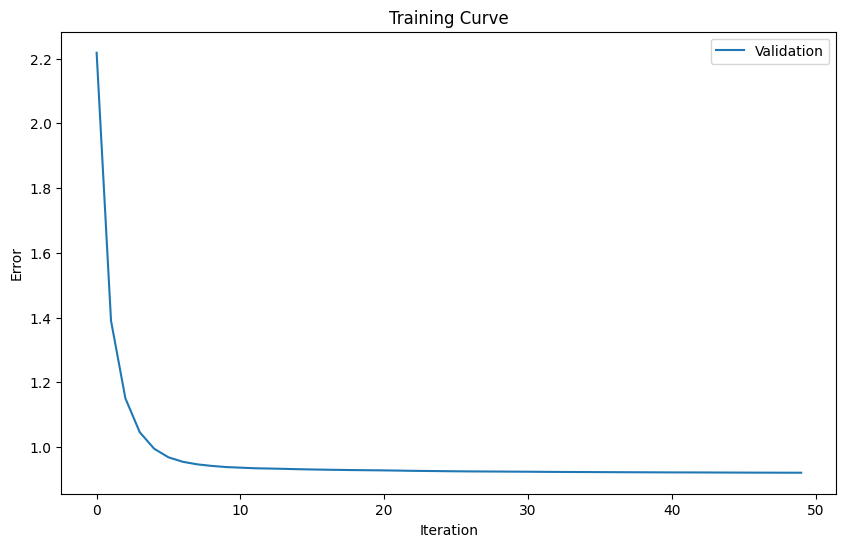

In [ ]:
cols_to_drop = [
    'user_id', 'date_account_created', 'timestamp_first_active', 'date_first_booking', 'age',
    'id_row_counts', 'days_to_book', 'logs_per_day', 'total_elapsed', 'booking', 'country_destination', 'month', 'day',
    'first_affiliate_tracked']

X = merged_df_with_tfidf.drop(cols_to_drop, axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'age_modified', 'affiliate_channel',
                'affiliate_provider',
                'most_frequent_device', 'first_browser', 'signup_flow', 'signup_app',
                'generation', 'language',  'first_device_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

model = CatBoostClassifier(iterations=500,
                            learning_rate=0.05,
                            depth=5,
                            loss_function = 'MultiClass',
                            eval_metric = 'AUC',
                            cat_features=cat_features,
                            random_seed=random_seed
                           )

# 학습 곡선 확인을 위한 리스트 초기화
train_error = []
validation_error = []


model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot = True)
y_pred_probs = model.predict_proba(X_test)

lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)


# 학습 과정에서의 에러 추출
train_error = model.evals_result_['validation']['MultiClass'][::10]  # 10 iterations마다 추출

# 에러 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_error)), train_error, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Training Curve')
plt.legend()
plt.show()

In [ ]:
ndcg = ndcg_score(lb.transform(y_test), y_pred_probs, k = 5)

print("NDCG Score:", ndcg)

NDCG Score: 0.8549070415287932


In [ ]:
model.save_model(path + 'all_included_MC.bin')

In [ ]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

Feature  Importance
9             age_modified   29.071461
78         booking_request   18.450820
10              generation    5.342392
1            signup_method    4.243702
268                pending    4.174378
..                     ...         ...
173          guest_receipt    0.000000
169  guest_billing_receipt    0.000000
168              guarantee    0.000000
167        google_importer    0.000000
443      zendesk_login_jwt    0.000000

[444 rows x 2 columns]

In [ ]:
np.percentile(feature_importance_df['Importance'], 90)

0.2729302841362913

In [ ]:
low_importance_feat = feature_importance_df[feature_importance_df['Importance'] <= 0.27]['Feature'].to_list()
low_importance_feat

['edit_profile',
 'message_thread',
 'edit',
 'post_checkout_action',
 'translate_listing_reviews',
 'calendar_tab_inner2',
 'login',
 'partner_callback',
 'kba',
 'most_frequent_device',
 'ajax_google_translate_reviews',
 'signup_app',
 'wishlist_content_update',
 'update_user',
 'personalize',
 'similar_listings',
 'recommended_listings',
 'dashboard',
 'change_contact_host_dates',
 'view_search_results',
 'connect',
 'user_wishlists',
 'your_listings',
 'unavailabilities',
 'kba_update',
 'send_message',
 'payment_methods',
 'show_personalize',
 'unknown',
 'your_trips',
 'search_results',
 'account_notification_settings',
 'push_notification_callback',
 'user_profile_content_update',
 '12',
 'phone_verification_modal',
 'active',
 'apply_reservation',
 'signup',
 'update',
 'wishlist',
 'edit_verification',
 'cancel',
 'oauth_response',
 'new',
 'pay',
 'populate_help_dropdown',
 'qt_reply_v2',
 'travel_plans_current',
 'track_page_view',
 'handle_vanity_url',
 'update_listing_desc

In [ ]:
len(low_importance_feat)

399

In [ ]:
cols_to_drop += low_importance_feat
len(cols_to_drop)

413

In [ ]:
X = merged_df_with_tfidf.drop(cols_to_drop, axis=1)
y = merged_df_with_tfidf['country_destination']

cat_features = ['gender', 'signup_method', 'age_modified', 'affiliate_channel',
                'first_browser', 'signup_flow',
                'generation', 'language',  'first_device_type']

# num_features = ['signup_flow', 'mean_secs_elapsed', 'session_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)

model = CatBoostClassifier(iterations=300,
                            learning_rate= 0.05,
                            depth= 5,
                            loss_function='MultiClass',
                            eval_metric = 'AUC',
                            cat_features=cat_features,
                            random_seed=random_seed
                           )

model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=20, plot=True)
y_pred_probs = model.predict_proba(X_test)

# 학습 곡선 확인을 위한 리스트 초기화
train_error = []
validation_error = []


lb = LabelBinarizer()
y_train_bin = lb.fit_transform(y_train)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.5660976	best: 0.5660976 (0)	total: 5.42s	remaining: 27m
20:	test: 0.5762364	best: 0.5768147 (19)	total: 1m 15s	remaining: 16m 46s
40:	test: 0.5835038	best: 0.5839900 (37)	total: 2m 12s	remaining: 13m 59s
60:	test: 0.5922868	best: 0.5922868 (60)	total: 3m 11s	remaining: 12m 29s
80:	test: 0.6054578	best: 0.6054578 (80)	total: 4m 10s	remaining: 11m 16s
100:	test: 0.6181903	best: 0.6181903 (100)	total: 5m 11s	remaining: 10m 14s
120:	test: 0.6237755	best: 0.6240159 (115)	total: 6m 11s	remaining: 9m 9s
140:	test: 0.6293563	best: 0.6296753 (139)	total: 7m 8s	remaining: 8m 3s
160:	test: 0.6327319	best: 0.6328037 (159)	total: 8m 3s	remaining: 6m 57s
180:	test: 0.6344068	best: 0.6346762 (175)	total: 9m	remaining: 5m 55s
200:	test: 0.6352242	best: 0.6363429 (188)	total: 9m 58s	remaining: 4m 54s
220:	test: 0.6361614	best: 0.6366640 (215)	total: 10m 56s	remaining: 3m 54s
240:	test: 0.6345075	best: 0.6366640 (215)	total: 11m 53s	remaining: 2m 54s
260:	test: 0.6340492	best: 0.6366640 (215)

KeyError: 'AUC'

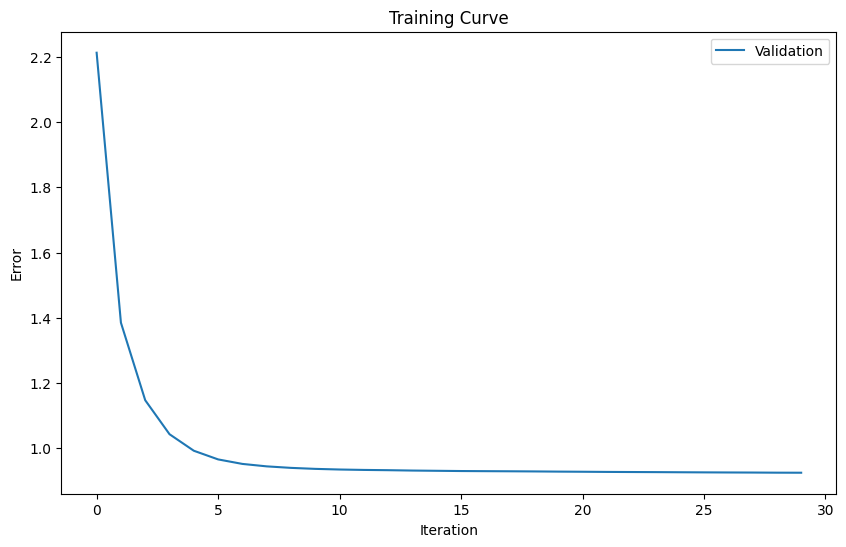

In [ ]:
# 학습 과정에서의 에러 추출
train_error = model.evals_result_['validation']['MultiClass'][::10]  # 10 iterations마다 추출

# 에러 시각화
plt.figure(figsize=(10, 6))
plt.plot(range(len(train_error)), train_error, label='Validation')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.title('Training Curve')
plt.legend()
plt.show()


In [ ]:
ndcg = ndcg_score(lb.transform(y_test), y_pred_probs)

print("NDCG Score:", ndcg)

NDCG Score: 0.865456854022617


In [ ]:
feature_importance = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance score in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

Feature  Importance
7                  age_modified   26.014912
15              booking_request    9.550450
8                    generation    9.234970
1                 signup_method    6.833407
5             first_device_type    3.929927
4             affiliate_channel    3.307451
36                           p5    2.742906
27                        error    2.057214
37                      pending    1.879807
18                        click    1.866489
2                   signup_flow    1.789702
32                 message_post    1.784807
10                session_count    1.766604
23                       create    1.695962
28                     identity    1.693036
42               update_listing    1.624165
0                        gender    1.565309
35  other_hosting_reviews_first    1.542271
17  change_trip_characteristics    1.505712
14                 authenticate    1.274382
24               create_listing    1.244117
20                confirm_email    1.193093
16        cancellation_policies    1.115953
33                           my    1.111121
43          update_user_profile    1.028472
12        ajax_refresh_subtotal    0.981582
11            ajax_lwlb_contact    0.872027
31               manage_listing    0.704493
38                          qt2    0.678066
22                 contact_host    0.676148
29        languages_multiselect    0.651158
3                      language    0.603300
34                notifications    0.583757
44                       verify    0.573167
21           confirm_email_link    0.553277
26                  create_user    0.525697
19              complete_status    0.491080
6                 first_browser    0.480430
30         listing_reviews_page    0.426088
39                    requested    0.416280
41         this_hosting_reviews    0.414610
40                     set_user    0.298658
9             mean_secs_elapsed    0.287154
25         create_phone_numbers    0.218263
13                 ask_question    0.212525

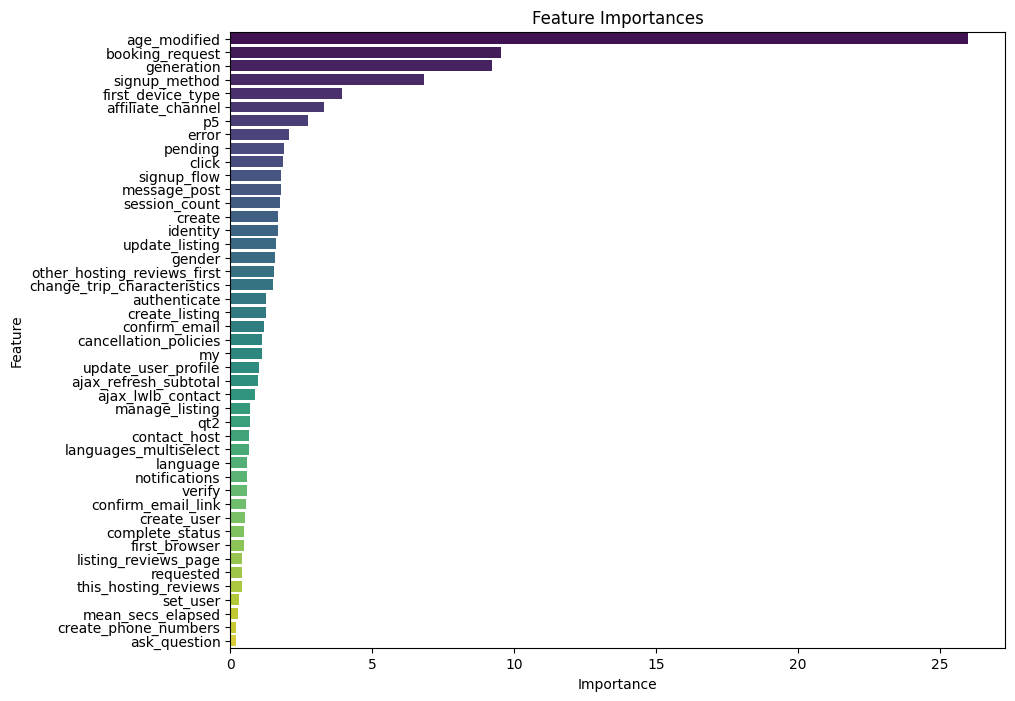

In [ ]:
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')

plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()

In [ ]:
model.save_model(path + 'optimized_MC.bin')

## test데이터에 대해서 진행